<a href="https://colab.research.google.com/github/weily-lang/weily-lang/blob/main/teamshares_data_engineering_screener_weily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas_datareader as pdr
import pandas as pd
from datetime import date

In [3]:
start_date = date(1980,1,1)
end_date = date(2021,1,1)


**Load data from the FRED dataset**

In [4]:
ten_year_treasury_rate = pdr.get_data_fred('T10Y2Y', start=start_date, end=end_date)
unemployment_rate = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
home_sales_median_price = pdr.get_data_fred('MSPUS', start=start_date, end=end_date)
cpi = pdr.get_data_fred('CPIAUCSL', start=start_date, end=end_date)
gdp = pdr.get_data_fred('GDP', start=start_date, end=end_date)

In [6]:
ten_year_treasury_rate[-5:]

,T10Y2Y
DATE,
2020-12-28,0.81
2020-12-29,0.82
2020-12-30,0.81
2020-12-31,0.80
2021-01-01,NaN


In [5]:
# Sample of the cpi data
cpi[-10:]

,CPIAUCSL
DATE,
2020-04-01,256.094
2020-05-01,255.944
2020-06-01,257.217
2020-07-01,258.543
2020-08-01,259.580
2020-09-01,260.190
2020-10-01,260.352
2020-11-01,260.721
2020-12-01,261.564


**(1) Combining Data**


How can we combine this data into one pandas DataFrame, such that each series is a column in the new DataFrame?

In [12]:
combined_df = ten_year_treasury_rate.join(
    [unemployment_rate, home_sales_median_price, cpi, gdp], how='outer'
)

combined_df

,T10Y2Y,UNRATE,MSPUS,CPIAUCSL,GDP
DATE,,,,,
1980-01-01,NaN,6.3,63700.0,78.0,2789.842
1980-01-02,-0.89,NaN,NaN,NaN,NaN
1980-01-03,-0.85,NaN,NaN,NaN,NaN
1980-01-04,-0.81,NaN,NaN,NaN,NaN
1980-01-07,-0.72,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-12-28,0.81,NaN,NaN,NaN,NaN
2020-12-29,0.82,NaN,NaN,NaN,NaN
2020-12-30,0.81,NaN,NaN,NaN,NaN


**(2) Handling missing values**


The datasets have different index values / date cadences, thus there are lots of NaN values. What are our options if we want to have a fully populated dataset for analysis? How do we choose which mechanism to use?



In [23]:
combined_df.interpolate(method='linear', inplace=True, limit_direction='both')
combined_df[:5]

,T10Y2Y,UNRATE,MSPUS,CPIAUCSL,GDP
DATE,,,,,
1980-01-01,-0.89,6.3,63700.000000,78.000000,2789.842000
1980-01-02,-0.89,6.3,63704.545455,78.043478,2789.955788
1980-01-03,-0.85,6.3,63709.090909,78.086957,2790.069576
1980-01-04,-0.81,6.3,63713.636364,78.130435,2790.183364
1980-01-07,-0.72,6.3,63718.181818,78.173913,2790.297152


**(3) Deriving new data**

How would we add a column that represents T10Y2Y / UNRATE ?

How could we get the maximum T10Y2Y grouped by month?

In [105]:
combined_df['T10Y2Y / UNRATE'] = combined_df.apply(lambda row: row.T10Y2Y/row.UNRATE, axis=1)

monthly_max_T10Y2Y = combined_df['T10Y2Y'].groupby(
      by=[combined_df.index.month, combined_df.index.year]
    ).max()

monthly_max_T10Y2Y_df = monthly_max_T10Y2Y.to_frame()

months = pd.to_datetime(combined_df.index.values).strftime('%Y-%m').drop_duplicates()

monthly_max_T10Y2Y_df.set_index(keys=months, inplace=True)
monthly_max_T10Y2Y_df

,T10Y2Y
1980-01,-0.62
1980-02,-0.13
1980-03,0.40
1980-04,1.24
1980-05,1.09
...,...
2020-09,1.34
2020-10,0.62
2020-11,0.21
2020-12,0.34


**(4) Visualizing the data**

How could we visualize this data to learn more about it? What do you notice from the visualization?

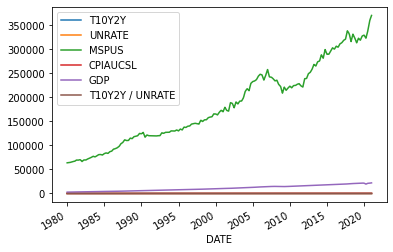

In [102]:
combined_df.plot()

**(5) Better Visualization**


Since the data has both rate / % data and absolute data with various scales, it can be difficult to visualize the data when it's combined all together. Do you have ideas on how we could improve the visualization?

In [ ]:
# multiple y axis, one for rate and one for absolute data

**(6) Better ways to look at home prices, CPI, and GDP**

It looks like they are all trending up over time, but have different levels and rates of change. Is there a better way to visualize what's happening?

How can we look at how the levels are changing over time?

In [ ]:
# derivatives

**(7) General stats**


How can you see some general stats about the data?

How could we look at a dataset that represents the rolling mean over 12 months at the end of each month?

In [106]:
# rolling window builtin


**(8) How can you understand the linear dependence of the data?**


What tools / techniques can we use to understand how each series is related to each other?

In [103]:
# My gut is to fit the data to a linear model to extrapolate the parameters in the linear model
# But I am not experienced in analyzing data with libraries, so I will recommend my colleague Jendri 
# (a math major who is my go-to for Pandas, bash and UNIX questions)

**(9) Discussion Questions**


- If we want to build a system to automatically collect this data from Fred on a regular basis, how would you design the system and what information would you need to do so?
    - How would you orchestrate the collection?
    - How would you store the data?
- What if the system had to be designed such that adding new datasets was configurable? e.g. we have the 5 datasets above, and we anticipate having to allow the user to add a new dataset for collection
- What types of data validations / checks would be important for this type of system?
- The downstream consumer of this data will want to be able to see similar transformations as described above. How would you make those transformstions available? What would you store versus compute?

In [ ]:
###
# To automatically collect the data on a regular basis, 
# I would write create a data store and grab new data on a scheduled cadence 
# to update the data store (relational tables 
# because the data is tightly coupled to dates and historical data indicates 
# a high number of rows).
# I'd use the OS to get the current date to pass in the current month 
# to grab data for the previous month.
# Downstream of grabbing the data, I would run the necessary interpolations, 
# calculations of rates, etc.

# If the user was to add a new dataset, I would create a new pipeline and downstream table for it.
###